# Quantum algorithm for linear system of equations

This notebook is used to generate the circuits that Qiskit uses for solving a linear system of equations. 

The algorthm is called the **HHL algorithm** (Harrow-Hassidim-Lloyd Algorithm). 

Here is a quick explanation of the procedure from wikipedia:
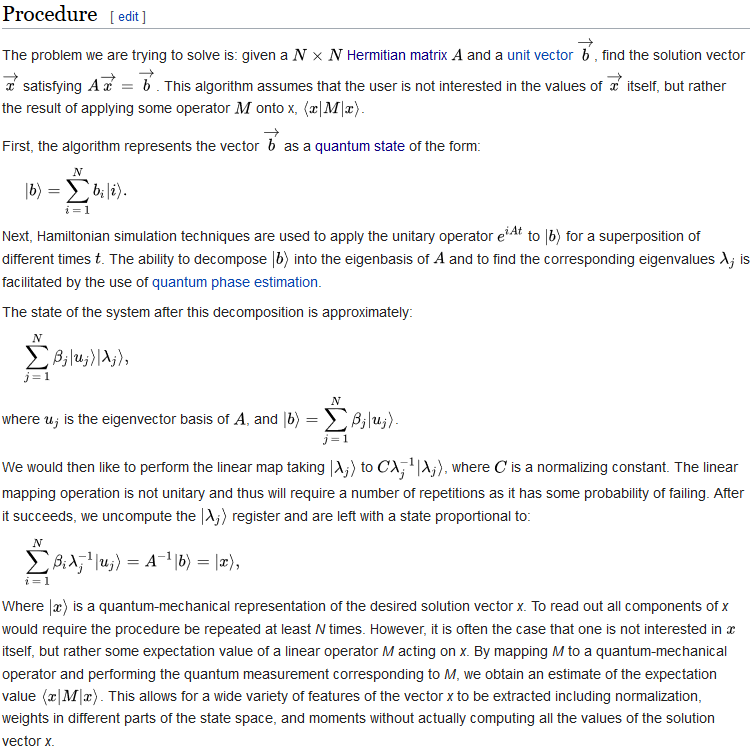

### Important note:
we're going to do this a little differently than the tutorials provided by Qiskit. Instead of using the 'run_algorithm' method, we're going to create an instance of the class HHL. 

This provides more control and let's us call the class methods easily. 
The method I am going to target is the `construct_circuit` method. Which, as the name implied, constructs the circuits.

However, I'm going to use the same matrices used in the tutorials because I want to compare my answers easily.

So...let's get started.

In [1]:
# some dependencies first
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.input import LinearSystemInput
from qiskit.aqua.algorithms.single_sample import HHL
from qiskit.aqua.algorithms.classical import ExactLSsolver
from qiskit.quantum_info import state_fidelity
import numpy as np
from qiskit import Aer, execute
%matplotlib inline

#### Matrices
First things first, let's define our matrices. These are the matrices we're going to use (first). This is a relatively simple equation to solve, which is exactly why we're going to target this first. 

**The HHL should be able to scale, and it is one of the fundamental quantum algorithms that should improve the run-time.**

Here are the matrices we will use:
![A_matrix](https://render.githubusercontent.com/render/math?math=A%3D%0A%5Cbegin%7Bbmatrix%7D%0A1%20%26amp%3B%200%20%5C%5C%0A0%20%26amp%3B%202%0A%5Cend%7Bbmatrix%7D&mode=display)
The corresponding vector will be:
![b_vector](https://render.githubusercontent.com/render/math?math=%5Cvec%7Bb%7D%3D%20%5Cleft%28%20%5Cbegin%7Barray%7D%7Bc%7D1%20%5C%5C%204%20%20%5Cend%7Barray%7D%20%5Cright%29&mode=display)

In [2]:
A_matrix = [[1,0],[0,2]]
b_vector = [1,4]

### Defining base parameters
In all the examples we will be using, we will use this dictionary of parameters are a "base". In other words, every linear system of equations will build a new set of parameters based on this one.


In [3]:
base_parameters = {
    'problem': {
        'name': 'linear_system'
    },
    'algorithm': {
        'name': 'HHL'
    },
    'eigs': {
        'expansion_mode': 'suzuki',
        'expansion_order': 2,
        'name': 'EigsQPE',
        'num_ancillae': 3,
        'num_time_slices': 50
    },
    'reciprocal': {
        'name': 'Lookup'
    },
    'backend': {
        'provider': 'qiskit.BasicAer',
        'name': 'statevector_simulator'
    }
}

### Customized parameters for hhl instance
Now that we've established the base parameters, we can add a few things (or change them in the future) to fit our particular problem. 

After that, we should define the input to the algorithm. 

In [4]:
instance_parameters = base_parameters

instance_parameters['algorithm'] = {
    'truncate_powerdim': False,
    'truncate_hermitian': False
}
instance_parameters['reciprocal'] = {
    'name': 'Lookup',
    'negative_evals': True
}
instance_parameters['eigs'] = {
    'expansion_mode': 'suzuki',
    'expansion_order': 2,
    'name': 'EigsQPE',
    'negative_evals': True,
    'num_ancillae': 3,
    'num_time_slices': 1
}
instance_parameters['initial_state'] = {
    'name': 'CUSTOM'
}
instance_parameters['iqft'] = {
    'name': 'STANDARD'
}
instance_parameters['qft'] = {
    'name': 'STANDARD'
}

algorithm_input = LinearSystemInput(matrix = A_matrix, 
                                    vector = b_vector)

## HHL instance
Now we are ready to create of an instance of the HHL class. 
We've definted all our parameters and algorithm inputs. 
we're going to use the ExactLSsolver, which is Qiskit's classical linear systems solver, to compare the solutions from a quantum LS solver and a classical LS solver. 

In [5]:
HHL_instance = HHL.init_params(instance_parameters, algorithm_input)

In [6]:
# establish the backend and quantum instance
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend = backend)

In [7]:
# run the quantum algorithm
HHL_results = HHL_instance.run(quantum_instance)

In [8]:
# run the classical algorithm
classical_results = ExactLSsolver(A_matrix, b_vector).run()

In [9]:
# let's look a tthe solutions
print("Quantum algorithm Solution = ", np.round(HHL_results['solution'],5))
print("Classical algorithm Solution = ", np.round(classical_results['solution'],5))

Quantum algorithm Solution =  [0.97534+0.j 2.00304+0.j]
Classical algorithm Solution =  [1. 2.]


# The Quantum Circuit
We will see that the quantum circuit used in this simulation is absolutely massive. We have set the `num_time_slices` down to 1 in order to fit it. Usually you would want more slices, however, for the purpose of viewing the circuit we had to use a number less than 20. 

Anything more than 20, you need to reconfigure your jupyter notebook in order to handle the size of the input. 

I've demonstrated that using 1 time slice will give a solution that is close enough for now. 

In [10]:
hhl_qc = HHL_instance.construct_circuit()
print(hhl_qc.draw())

           ┌────────────────┐┌───────┐┌─────────────┐┌───┐┌──────────────┐┌───┐»
  io_0: |0>┤ U3(2.6516,0,0) ├┤ U1(0) ├┤ U1(0.14242) ├┤ X ├┤ U1(-0.14242) ├┤ X ├»
           └┬──────────────┬┘└───────┘└─────────────┘└─┬─┘└──────────────┘└─┬─┘»
  q4_0: |0>─┤ U2(0,3.1416) ├───────────────────────────■────────────────────■──»
            ├──────────────┤                                                   »
  q4_1: |0>─┤ U2(0,3.1416) ├───────────────────────────────────────────────────»
            ├──────────────┤                                                   »
  q4_2: |0>─┤ U2(0,3.1416) ├───────────────────────────────────────────────────»
            ├──────────────┤                                                   »
  q4_3: |0>─┤ U2(0,3.1416) ├───────────────────────────────────────────────────»
            └──────────────┘                                                   »
work_0: |0>────────────────────────────────────────────────────────────────────»
                            

In [11]:
# some information about the circuit
print("circuit width = ", hhl_qc.width())
print("circuit depth =", hhl_qc.depth())
print("circuit operations used: ", hhl_qc.count_ops())

circuit width =  8
circuit depth = 687
circuit operations used:  {'u3': 97, 'u1': 289, 'u2': 28, 'cx': 370, 'cu1': 6, 'x': 28, 'cu3': 1}


In [12]:
print(hhl_qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg io[1];
qreg q4[4];
qreg work[1];
qreg msq[1];
qreg anc[1];
u3(2.65163532733607,0,0) io[0];
u1(0) io[0];
u2(0,3.14159265358979) q4[0];
u2(0,3.14159265358979) q4[1];
u2(0,3.14159265358979) q4[2];
u2(0,3.14159265358979) q4[3];
u1(0.142423877274216) io[0];
cx q4[0],io[0];
u1(-0.142423877274216) io[0];
cx q4[0],io[0];
u1(0.142423877274216) io[0];
cx q4[0],io[0];
u1(-0.142423877274216) io[0];
cx q4[0],io[0];
u1(0.142423877274216) io[0];
cx q4[0],io[0];
u1(-0.142423877274216) io[0];
cx q4[0],io[0];
u1(0.142423877274216) io[0];
cx q4[0],io[0];
u1(-0.142423877274216) io[0];
cx q4[0],io[0];
u1(-0.226083812610480) io[0];
cx q4[0],io[0];
u1(0.226083812610480) io[0];
cx q4[0],io[0];
u1(-0.226083812610480) io[0];
cx q4[0],io[0];
u1(0.226083812610480) io[0];
cx q4[0],io[0];
u1(0.142423877274216) io[0];
cx q4[0],io[0];
u1(-0.142423877274216) io[0];
cx q4[0],io[0];
u1(0.142423877274216) io[0];
cx q4[0],io[0];
u1(-0.142423877274216) io[0];
cx q4[0],io[0];
u1(0.14